In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import tensorflow as tf

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_digits,load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
 
mnist = pd.read_csv('mnist-in-csv/mnist_test.csv')
# for test in testing_set:
#     if sklearn_knn.predict(test) == your_knn(test, features, labels, k = 1):
#         print "Error in " + str(test)

In [3]:
mnist_data = np.array(mnist[mnist.columns[1:]])

In [4]:
mnist_labels = np.array(mnist[mnist.columns[0]])
mnist_data.shape

(10000, 784)

In [5]:
# X_train, X_test, y_train, y_test = train_test_split(mnist_data[:3000], mnist_labels[:3000], test_size=0.1,
#                                                    random_state=11)
def split_data(x,y,test_size):
    size=len(x)
    train_idx_start = 0
    train_idx_stop = int(size*(1-test_size))
    test_idx_start = train_idx_stop
    test_idx_stop = train_idx_stop + int(size*test_size)
    x_train = np.array(x[0:train_idx_stop])
    x_test = np.array(y[0:train_idx_stop])
    y_train = np.array(x[test_idx_start:test_idx_stop])
    y_test =  np.array(y[test_idx_start:test_idx_stop])
    return x_train, x_test, y_train, y_test
    
X_train, y_train, X_test, y_test = split_data(mnist_data[:3000],mnist_labels[:3000],test_size=0.1)
    

In [6]:
X_train = X_train/255
X_test = X_test/255
sklearn_knn = KNeighborsClassifier(n_neighbors=2)
sklearn_knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [7]:
X_test.shape

(300, 784)

In [8]:
def show_mnist_image(arr):
    plt.imshow(arr.reshape((28,28)))

In [9]:
sklearn_knn.predict(X_test[65].reshape(1,-1))

array([0])

In [10]:
accuracy_score(y_true=y_test, y_pred=sklearn_knn.predict(X_test))

0.92

In [11]:
# !pip install NearPy

In [12]:
### incorporating multiple tables
class LSH_:
    def __init__(self,hash_size,data_dim,num_tables):
        self.num_rand_vec = hash_size  # number of buckets will be 2**hash_size eg: 2**2=4 (00,01,10,11)
        self.dim = data_dim
        self.num_tables = num_tables
        self.hash_tables = [{} for _ in range(self.num_tables)]
        self.seeds = [i for i in range(self.num_tables)]
        self.random_vectors = []
        for seed in self.seeds:
            np.random.seed(seed)
            self.random_vectors.append(self.gen_random_vectors())
    
    def gen_random_vectors(self):
        rand_vec_matrix = np.random.randn(self.num_rand_vec,self.dim)
        return rand_vec_matrix
    
    
    def make_hash_key(self,inp):
        return ''.join(inp)
    
    def fit(self,data):
        assert data.shape[1] == self.dim, 'dimension of input data is {} and dimension in LSH object is {}'.format(data.shape,self.dim)
        for rand_vec,hash_table in zip(self.random_vectors,self.hash_tables): #, seed in zip(self.hash_tables,self.seeds):
#             np.random.seed(seed)
#             rand_vecs = self.gen_random_vectors()
#             bools = (np.dot(data, rand_vec.T) > 0).astype('int')
            keys = list(map(self.make_hash_key , (np.dot(data, rand_vec.T) > 0).astype('int').astype('str')))
            unique_keys = set(keys)
            for key in unique_keys:
                hash_table[key] = []
            for idx,k in enumerate(keys):
                hash_table[k].append(idx)
        return 'success'
    
    def hash_table(self):
        return self.hash_tables
        
    def hash_table_dist(self):
        distribuitions = []
        for hash_table in self.hash_tables:
            summary_of_table = {}
            for k,v in hash_table.items():
                summary_of_table[k] = len(v)
            distribuitions.append(summary_of_table)
        return distribuitions   
    
    def query(self,query_data):
        key_for_each_table = []
        for rand_vec in self.random_vectors:
            key = ''.join((np.dot(query_data, rand_vec.T) > 0).astype('int').astype('str'))
            key_for_each_table.append(key) #each point will be assigned to exactly on bucket in one hash table
        result = []
        assert len(key_for_each_table) == len(self.hash_tables), 'somethings wrong'
        for hash_table,key in zip(self.hash_tables,key_for_each_table):
            if key in hash_table.keys():
                result.extend(hash_table[key])
#         print(keys_for_each_table)
        return set(result)
            

In [13]:
lsh_= LSH_(hash_size=6,data_dim=784,num_tables=20)

In [14]:
lsh_.fit(X_train)

'success'

In [17]:
# lsh_.hash_table_dist()

In [19]:
query = X_test[8]
print('number of candidates:',len(lsh_.query(query)))
# (lsh_.query(query))

number of candidates: 1614


In [30]:
# doc = 71
# show_mnist_image(X_train[doc]),y_train[doc]

(None, 7)

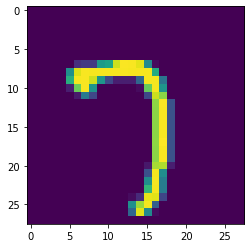

In [31]:
rand_doc = 0
show_mnist_image(X_test[rand_doc]),y_test[rand_doc]

In [23]:
from sklearn.metrics.pairwise import cosine_similarity

In [34]:
query_doc = X_test[rand_doc]
candidate_docs = list(lsh_.query(query_doc))
len(candidate_docs)

1797

In [35]:
sims = cosine_similarity(X_train,query_doc.reshape(1,-1))
sims

array([[0.44833679],
       [0.1718019 ],
       [0.13904763],
       ...,
       [0.33203843],
       [0.3751672 ],
       [0.22354439]])

In [36]:
max_sim_idx = sims.argmax()
max_sim_idx, sims[max_sim_idx]

(585, array([0.86608442]))

In [37]:
doc = X_train[max_sim_idx]

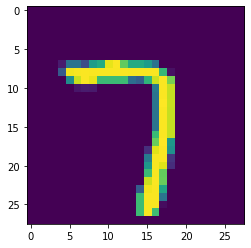

In [38]:
show_mnist_image(doc)

In [39]:
def lsh_prediction(test_doc):
    candidate_docs = list(lsh_.query(test_doc))
    sims = cosine_similarity(mnist_data[[candidate_docs]],test_doc.reshape(1,-1))
    max_sim_idx = sims.argmax()
    prediction = y_train[candidate_docs[max_sim_idx]]
    return prediction

In [40]:
acc = 0
predictions = []
for test_doc,label in zip(X_test[:50],y_test[:50]):
    predictions.append(lsh_prediction(test_doc))
    if label == lsh_prediction(test_doc):
        acc+=1
acc_ = acc/len(y_test)

/home/gurmukh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/gurmukh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/gurmukh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensiona

/home/gurmukh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/gurmukh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/gurmukh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensiona

/home/gurmukh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/gurmukh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/gurmukh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensiona

/home/gurmukh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/gurmukh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/gurmukh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensiona

In [43]:
# lsh_prediction(X_test[10])

In [41]:
acc_

0.16

In [21]:
import tensorflow as tf

In [43]:
data = tf.placeholder("float", [None, 784])
rand_hash_vec = tf.placeholder("float", [None, 784])
distance_matrix = tf.matmul(data,tf.transpose(rand_hash_vec))
euclidean_dist = tf.sqrt(tf.reduce_sum(distance_matrix ** 2, axis=1))
# keys = list(map(make_hash_key, (distance_matrix > 0).astype('int').astype('str')))

In [53]:
with tf.Session() as sess:
    _,eucl_dist = sess.run([distance_matrix,euclidean_dist], feed_dict={data: X_train, rand_hash_vec: np.random.randn(8,784)})
    print(euc_dist.shape)

(2700,)


In [54]:
(euc_dist>0).astype('int')

array([1, 1, 1, ..., 1, 1, 1])

In [55]:
eucl_dist

array([18.979568, 23.761368, 17.097902, ..., 19.860703, 20.051308,
       11.94329 ], dtype=float32)

In [45]:
tf.test.gpu_device_name()

''